# 02 - Data Exploration & Visualization

This notebook provides detailed visualization of gesture sequences and hand landmarks.

## Objectives
1. Visualize individual gesture sequences
2. Plot hand landmark connections
3. Create gesture animations
4. Compare raw vs normalized keypoints
5. Identify distinguishing patterns between gestures

In [11]:
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Imports loaded")

✅ Imports loaded


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import argparse
from pathlib import Path

# MediaPipe Hand Connections (Indices)
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),    # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),    # Index
    (0, 9), (9, 10), (10, 11), (11, 12), # Middle
    (0, 13), (13, 14), (14, 15), (15, 16), # Ring
    (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
]

def visualize_sequence(npz_path, sample_idx=0, split='X_train'):
    """
    Loads normalized data and animates it.
    Since data is wrist-centered, Wrist (Idx 0) should stay at (0,0,0).
    """
    if not Path(npz_path).exists():
        print(f"Error: File {npz_path} not found.")
        return

    data = np.load(npz_path, allow_pickle=True)
    
    if split not in data:
        print(f"Error: Split {split} not found in {npz_path}. Available: {list(data.keys())}")
        return
        
    X = data[split] # Shape (N, T, 67)
    
    if sample_idx >= len(X):
        print(f"Error: Index {sample_idx} out of bounds (Size: {len(X)})")
        return

    # Extract sequence: (T, 67)
    # Feature 0-63 are XYZ coordinates for 21 landmarks
    seq_flat = X[sample_idx]
    T = seq_flat.shape[0]
    
    # Reshape features to (T, 21, 3)
    # We ignore the last 4 features (pinch distances)
    landmarks = seq_flat[:, :63].reshape(T, 21, 3)
    
    # Setup Plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=-90, azim=-90) # Top-down view approx
    
    # Determine bounds for consistent scale
    all_x = landmarks[:, :, 0].flatten()
    all_y = landmarks[:, :, 1].flatten()
    all_z = landmarks[:, :, 2].flatten()
    
    min_x, max_x = all_x.min(), all_x.max()
    min_y, max_y = all_y.min(), all_y.max()
    min_z, max_z = all_z.min(), all_z.max()

    def update(frame):
        ax.clear()
        ax.set_title(f"Frame {frame}/{T} (Normalized)")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # Set consistent fixed limits
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_zlim(min_z, max_z)
        
        # Get Frame Landmarks
        lms = landmarks[frame] # (21, 3)
        
        # Plot Joints
        ax.scatter(lms[:, 0], lms[:, 1], lms[:, 2], c='red', s=20)
        
        # Plot Wrist specifically
        ax.scatter(lms[0, 0], lms[0, 1], lms[0, 2], c='blue', s=50, label='Wrist (Origin)')
        
        # Plot Bones
        for start, end in HAND_CONNECTIONS:
            xs = [lms[start, 0], lms[end, 0]]
            ys = [lms[start, 1], lms[end, 1]]
            zs = [lms[start, 2], lms[end, 2]]
            ax.plot(xs, ys, zs, c='black')
            
        ax.legend()

    anim = FuncAnimation(fig, update, frames=T, interval=100)
    plt.show()


visualize_sequence(args.file, args.idx)


NameError: name 'args' is not defined

In [19]:
# Configuration
DATA_PATH = Path('../data/raw/left_mp_data')
if not DATA_PATH.exists():
    DATA_PATH = Path('../ModelTraining/MP_Data')

ACTIONS = ['none', 'horizontal_swipe', 'zoom', 'pointyclick', 'middleclick', 'touch']

# MediaPipe hand landmark connections
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),      # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),      # Index
    (0, 9), (9, 10), (10, 11), (11, 12), # Middle
    (0, 13), (13, 14), (14, 15), (15, 16), # Ring
    (0, 17), (17, 18), (18, 19), (19, 20), # Pinky
    (5, 9), (9, 13), (13, 17)            # Palm
]

# Landmark names
LANDMARK_NAMES = [
    'WRIST',
    'THUMB_CMC', 'THUMB_MCP', 'THUMB_IP', 'THUMB_TIP',
    'INDEX_MCP', 'INDEX_PIP', 'INDEX_DIP', 'INDEX_TIP',
    'MIDDLE_MCP', 'MIDDLE_PIP', 'MIDDLE_DIP', 'MIDDLE_TIP',
    'RING_MCP', 'RING_PIP', 'RING_DIP', 'RING_TIP',
    'PINKY_MCP', 'PINKY_PIP', 'PINKY_DIP', 'PINKY_TIP'
]

print(f"📁 Data path: {DATA_PATH}")

📁 Data path: ../data/raw/left_mp_data


## 1. Load Sample Sequences

In [20]:
def load_sequence(data_path, action, sequence_idx=0):
    """
    Load a single sequence for a gesture.
    
    Returns:
        sequence: np.array of shape (16, 84)
    """
    action_path = data_path / action
    seq_dirs = sorted([d for d in action_path.iterdir() if d.is_dir()])
    
    if sequence_idx >= len(seq_dirs):
        sequence_idx = 0
    
    seq_dir = seq_dirs[sequence_idx]
    frames = []
    
    for frame_num in range(12):
        frame_path = seq_dir / f"{frame_num}.npy"
        if frame_path.exists():
            frames.append(np.load(frame_path))
    
    return np.array(frames)

def reshape_to_landmarks(frame):
    """
    Reshape flat frame (84,) to landmarks (21, 4).
    
    Returns:
        landmarks: np.array of shape (21, 4) - x, y, z, visibility
    """
    return frame.reshape(21, 4)

# Load sample sequences for each gesture
sample_sequences = {}
for action in ACTIONS:
    try:
        sample_sequences[action] = load_sequence(DATA_PATH, action, sequence_idx=1)
        print(f"✅ Loaded {action}: {sample_sequences[action].shape}")
    except Exception as e:
        print(f"❌ Failed to load {action}: {e}")

✅ Loaded none: (12, 84)
✅ Loaded horizontal_swipe: (12, 84)
❌ Failed to load zoom: [Errno 2] No such file or directory: '../data/raw/left_mp_data/zoom'
❌ Failed to load pointyclick: [Errno 2] No such file or directory: '../data/raw/left_mp_data/pointyclick'
❌ Failed to load middleclick: [Errno 2] No such file or directory: '../data/raw/left_mp_data/middleclick'
✅ Loaded touch: (12, 84)


## 2. Visualize Hand Landmarks

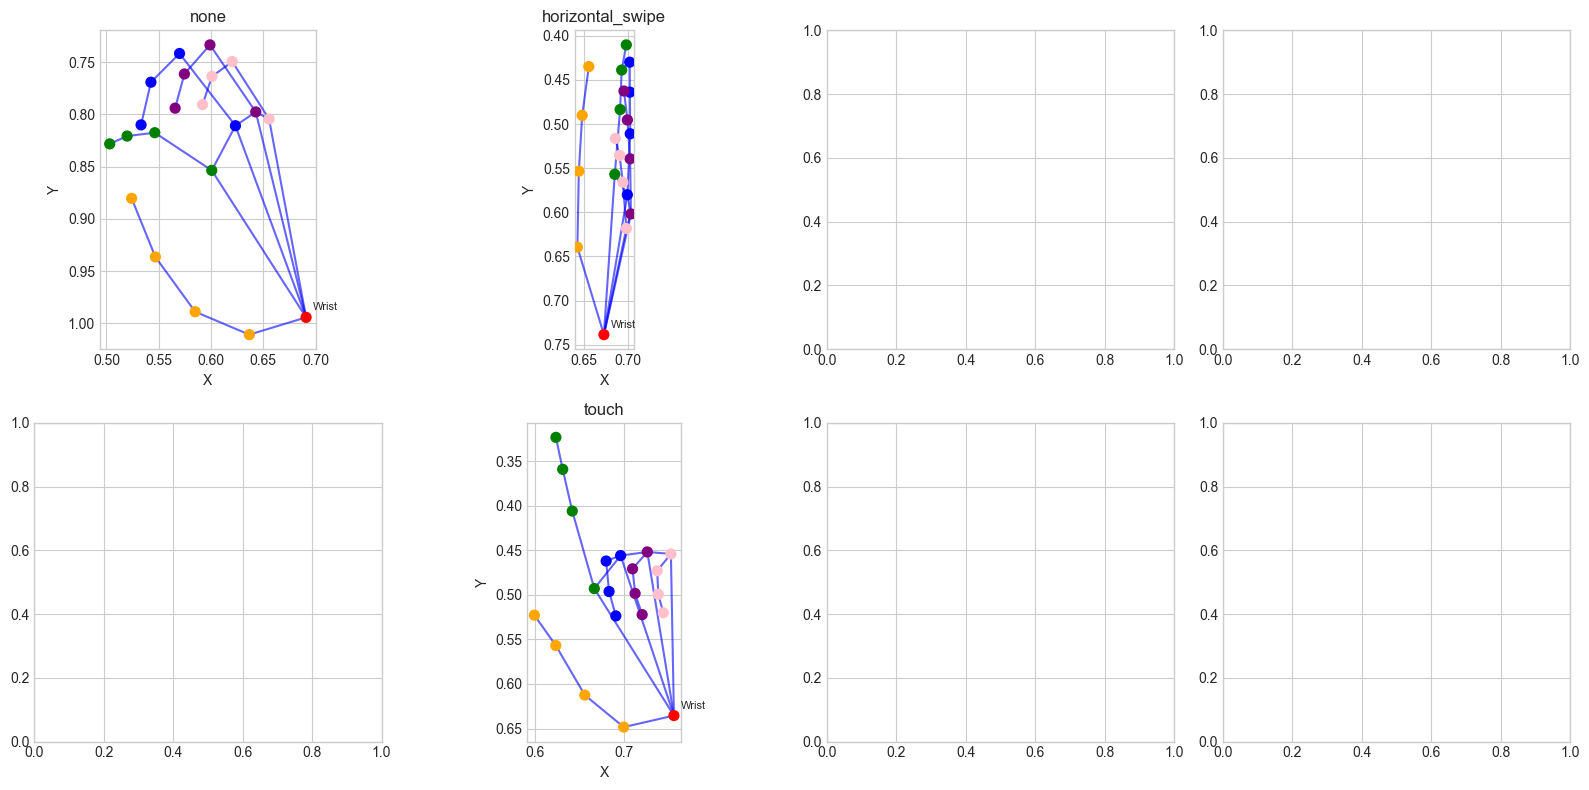

In [21]:
def plot_hand_2d(landmarks, ax, title='Hand Landmarks'):
    """
    Plot 2D hand landmarks with connections.
    
    Args:
        landmarks: np.array of shape (21, 4) - x, y, z, visibility
        ax: matplotlib axis
        title: plot title
    """
    # Extract x, y coordinates
    x = landmarks[:, 0]
    y = landmarks[:, 1]
    
    # Plot connections
    for connection in HAND_CONNECTIONS:
        start, end = connection
        ax.plot([x[start], x[end]], [y[start], y[end]], 'b-', linewidth=1.5, alpha=0.6)
    
    # Plot landmarks with color coding by finger
    colors = ['red'] + ['orange']*4 + ['green']*4 + ['blue']*4 + ['purple']*4 + ['pink']*4
    ax.scatter(x, y, c=colors, s=50, zorder=5)
    
    # Annotate wrist
    ax.annotate('Wrist', (x[0], y[0]), textcoords='offset points', xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.invert_yaxis()  # Match image coordinates
    ax.set_aspect('equal')

# Plot first frame of each gesture
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, action in enumerate(ACTIONS):
    if action in sample_sequences:
        first_frame = sample_sequences[action][0]
        landmarks = reshape_to_landmarks(first_frame)
        plot_hand_2d(landmarks, axes[idx], title=action)

plt.tight_layout()
plt.savefig('../docs/hand_landmarks_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
import matplotlib.pyplot as plt

def plot_action(action_frames):
    # 1️⃣ Create a 2x8 figure
    fig, axes = plt.subplots(2, 8, figsize=(24, 6))

    # axes is 2D → make it 1D so we can loop
    axes = axes.flatten()

    # 2️⃣ Loop through 16 frames
    for i in range(12):
        plot_hand_2d(
            action_frames[i].reshape(21,4),   # ONE frame
            axes[i],             # ONE subplot
            title=f"Frame {i}"
        )

    # 3️⃣ Remove gaps → maximize size
    plt.subplots_adjust(
        left=0.01,
        right=0.99,
        top=0.95,
        bottom=0.05,
        wspace=0.02,
        hspace=0.05
    )

    plt.show()


=== none's frames ===


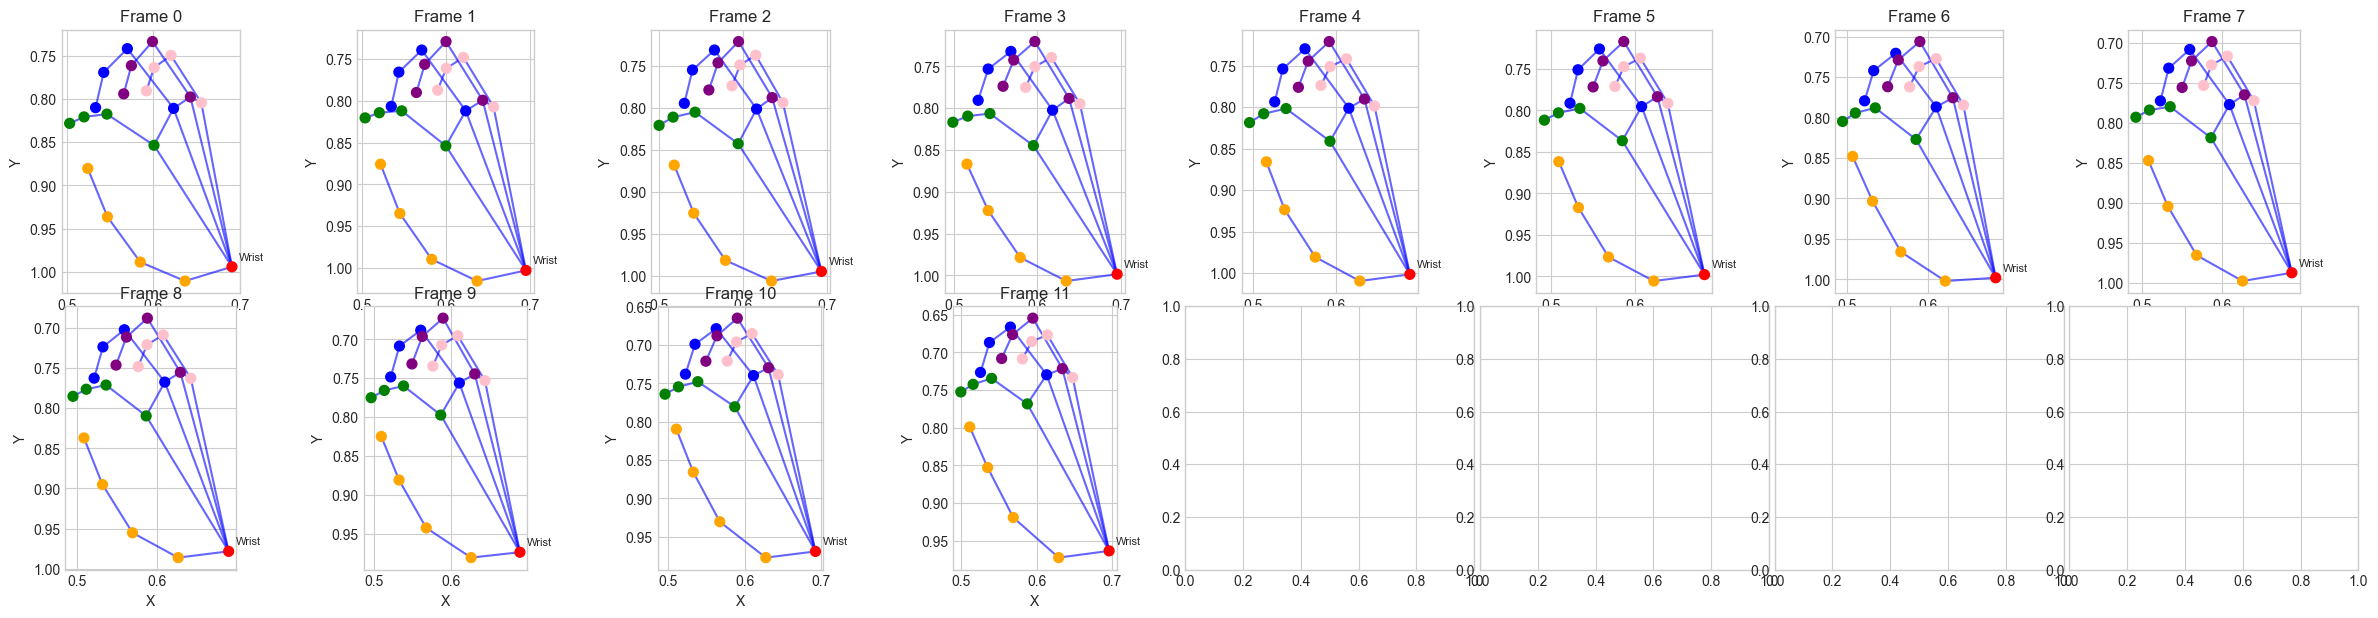

=== horizontal_swipe's frames ===


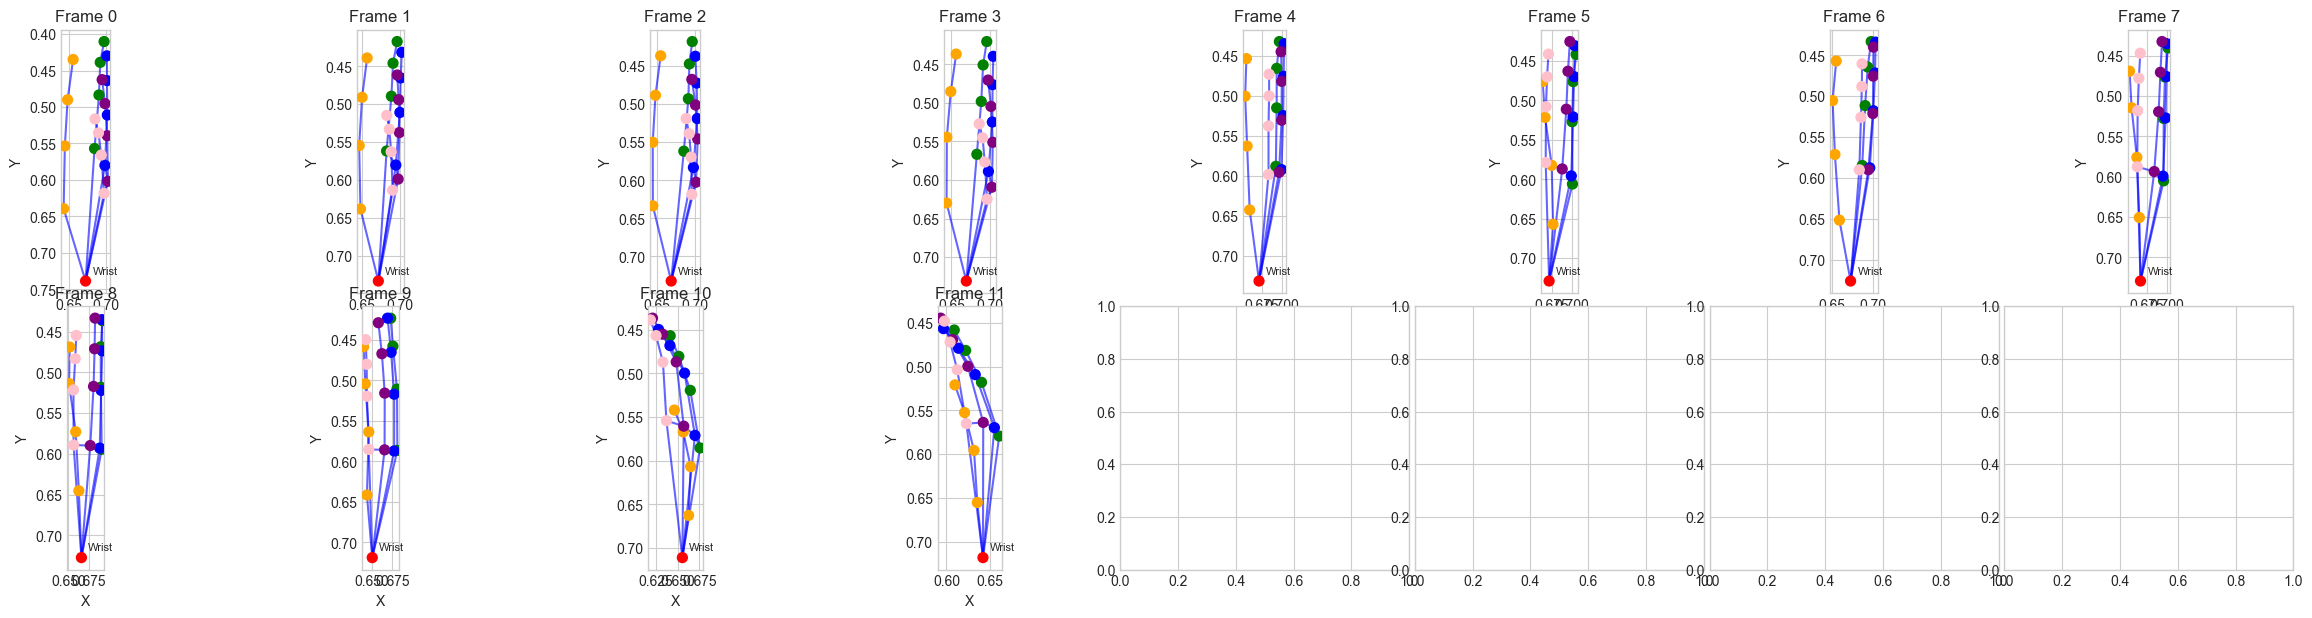

=== touch's frames ===


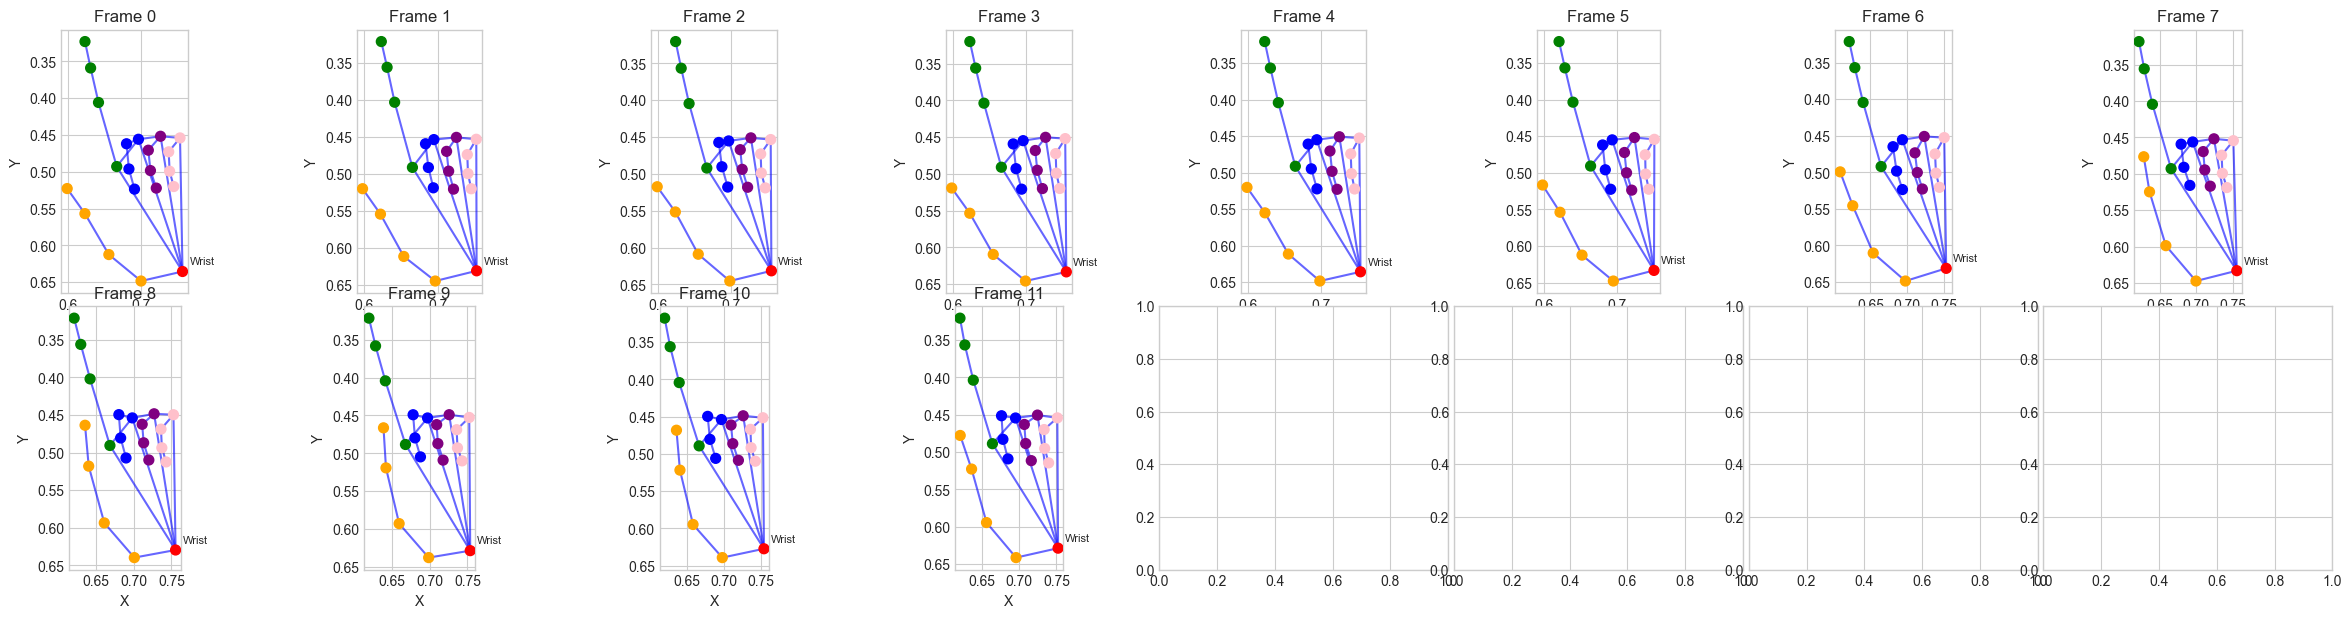

In [23]:
for action in sample_sequences: 
    print(f"=== {action}'s frames ===")
    plot_action(sample_sequences[action])

In [24]:
plot_action(sample_sequences["swiperight"])

KeyError: 'swiperight'

In [11]:
sample_sequences["none"].shape

KeyError: 'none'

## 4. Gesture Sequence Animation

In [63]:
from IPython.display import HTML, display

def create_gesture_animation(sequence, title='Gesture Animation'):
    """
    Create an animation of a gesture sequence.
    
    Args:
        sequence: np.array of shape (16, 84)
    
    Returns:
        matplotlib animation object
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    def animate(frame_idx):
        ax.clear()
        frame = sequence[frame_idx]
        landmarks = reshape_to_landmarks(frame)
        plot_hand_2d(landmarks, ax, title=f"{title} - Frame {frame_idx + 1}/12")
        return ax,
    
    anim = animation.FuncAnimation(fig, animate, frames=14, interval=100, blit=False)
    plt.close()
    return anim

# Create animation for a gesture
for action in sample_sequences: 
    if gesture_to_animate in sample_sequences:
        anim = create_gesture_animation(sample_sequences[action], title=action)
        display(HTML(anim.to_jshtml()))

## 5. Compare Gesture Trajectories

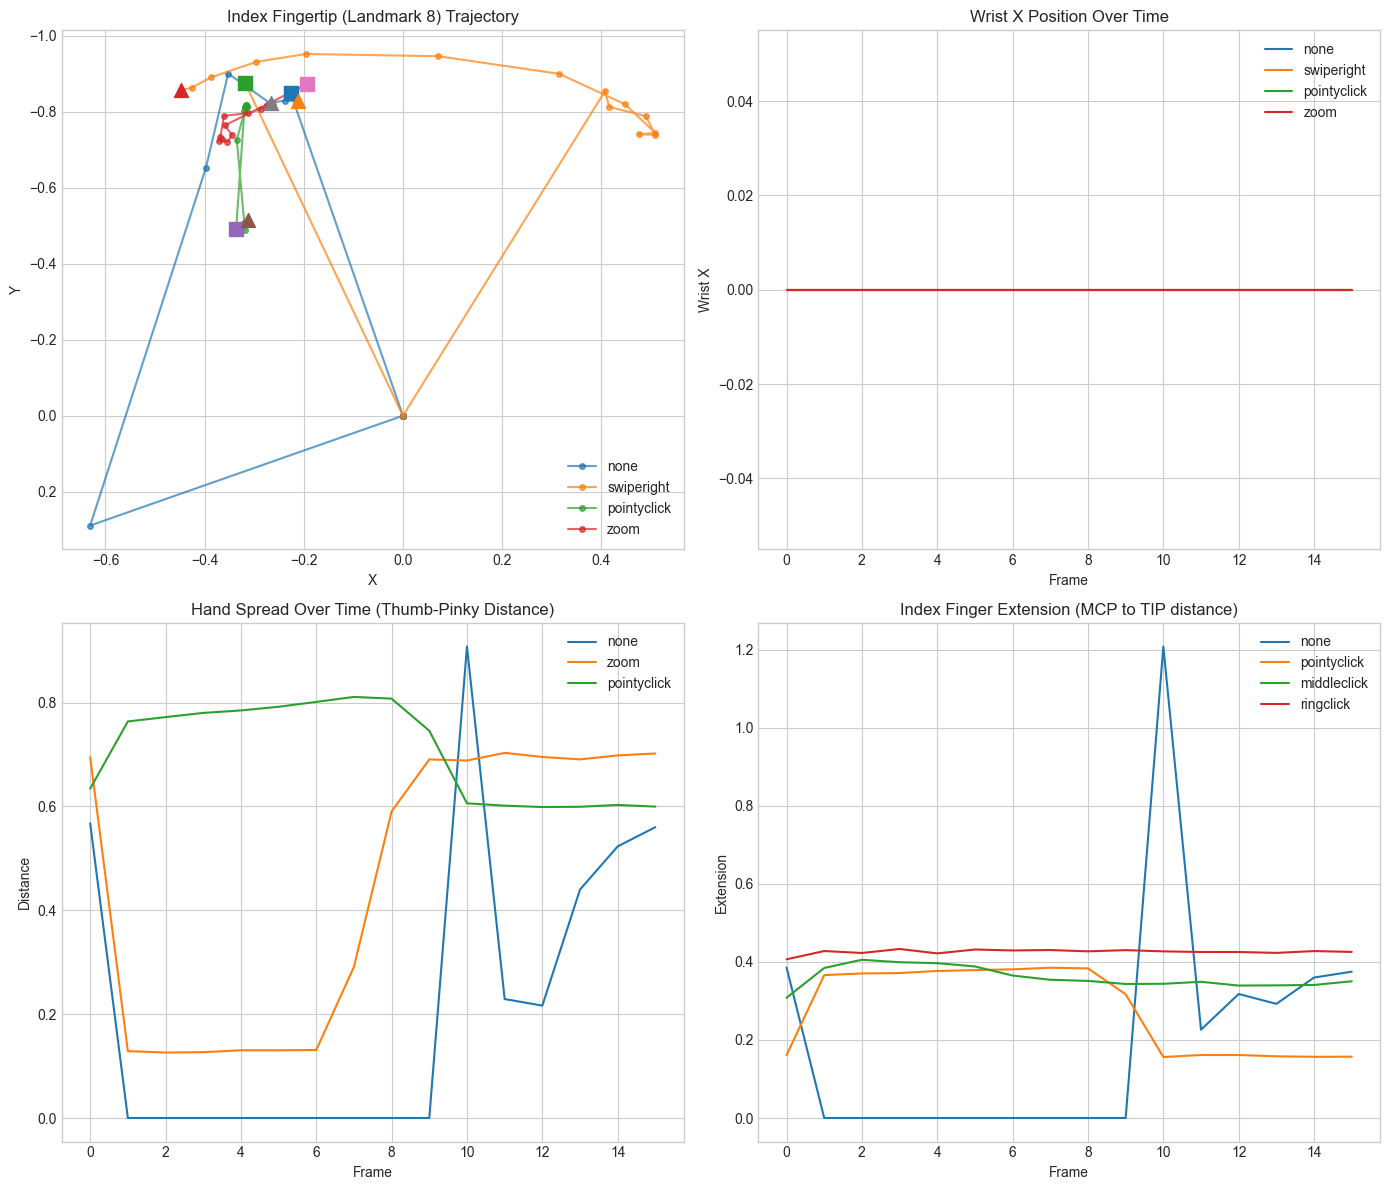

In [31]:
# Compare finger tip trajectories across gestures
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Index fingertip trajectory (landmark 8)
axes[0, 0].set_title('Index Fingertip (Landmark 8) Trajectory')
for action in ['none', 'swiperight', 'pointyclick', 'zoom']:
    if action in sample_sequences:
        seq = sample_sequences[action]
        # Get index finger tip x, y over time
        tip_x = seq[:, 8*4]      # x of landmark 8
        tip_y = seq[:, 8*4 + 1]  # y of landmark 8
        axes[0, 0].plot(tip_x, tip_y, 'o-', label=action, alpha=0.7, markersize=4)
        # Mark start and end
        axes[0, 0].scatter(tip_x[0], tip_y[0], s=100, marker='s', zorder=5)
        axes[0, 0].scatter(tip_x[-1], tip_y[-1], s=100, marker='^', zorder=5)

axes[0, 0].set_xlabel('X')
axes[0, 0].set_ylabel('Y')
axes[0, 0].legend()
axes[0, 0].invert_yaxis()

# Wrist movement over time
axes[0, 1].set_title('Wrist X Position Over Time')
for action in ['none', 'swiperight', 'pointyclick', 'zoom']:
    if action in sample_sequences:
        wrist_x = sample_sequences[action][:, 0]
        axes[0, 1].plot(wrist_x, label=action)

axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Wrist X')
axes[0, 1].legend()

# Hand spread (distance between thumb and pinky tips)
axes[1, 0].set_title('Hand Spread Over Time (Thumb-Pinky Distance)')
for action in ['none', 'zoom', 'pointyclick']:
    if action in sample_sequences:
        seq = sample_sequences[action]
        # Thumb tip (4) and Pinky tip (20)
        thumb_x, thumb_y = seq[:, 4*4], seq[:, 4*4 + 1]
        pinky_x, pinky_y = seq[:, 20*4], seq[:, 20*4 + 1]
        distance = np.sqrt((thumb_x - pinky_x)**2 + (thumb_y - pinky_y)**2)
        axes[1, 0].plot(distance, label=action)

axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Distance')
axes[1, 0].legend()

# Finger extension comparison
axes[1, 1].set_title('Index Finger Extension (MCP to TIP distance)')
for action in ['none', 'pointyclick', 'middleclick', 'ringclick']:
    if action in sample_sequences:
        seq = sample_sequences[action]
        # Index MCP (5) to Index TIP (8)
        mcp_x, mcp_y = seq[:, 5*4], seq[:, 5*4 + 1]
        tip_x, tip_y = seq[:, 8*4], seq[:, 8*4 + 1]
        extension = np.sqrt((tip_x - mcp_x)**2 + (tip_y - mcp_y)**2)
        axes[1, 1].plot(extension, label=action)

axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Extension')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../docs/gesture_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Distinguishing Features Analysis

In [32]:
def compute_gesture_features(sequence):
    """
    Compute distinguishing features from a gesture sequence.
    
    Returns:
        dict of feature values
    """
    features = {}
    
    # Wrist movement
    wrist_x = sequence[:, 0]
    wrist_y = sequence[:, 1]
    features['wrist_x_range'] = wrist_x.max() - wrist_x.min()
    features['wrist_y_range'] = wrist_y.max() - wrist_y.min()
    features['wrist_total_distance'] = np.sum(np.sqrt(np.diff(wrist_x)**2 + np.diff(wrist_y)**2))
    
    # Hand spread (zoom detection)
    thumb_tip = sequence[:, 4*4:4*4+2]
    pinky_tip = sequence[:, 20*4:20*4+2]
    spread = np.linalg.norm(thumb_tip - pinky_tip, axis=1)
    features['spread_mean'] = spread.mean()
    features['spread_change'] = spread[-1] - spread[0]
    
    # Individual finger extensions
    for finger_name, mcp_idx, tip_idx in [('index', 5, 8), ('middle', 9, 12), ('ring', 13, 16), ('pinky', 17, 20)]:
        mcp = sequence[:, mcp_idx*4:mcp_idx*4+2]
        tip = sequence[:, tip_idx*4:tip_idx*4+2]
        extension = np.linalg.norm(tip - mcp, axis=1)
        features[f'{finger_name}_extension_mean'] = extension.mean()
        features[f'{finger_name}_extension_std'] = extension.std()
    
    # Overall velocity
    velocity = np.diff(sequence, axis=0)
    features['velocity_mean'] = np.linalg.norm(velocity, axis=1).mean()
    
    return features

# Compute features for all gestures
feature_data = []
for action in ACTIONS:
    if action in sample_sequences:
        features = compute_gesture_features(sample_sequences[action])
        features['gesture'] = action
        feature_data.append(features)

df_features = pd.DataFrame(feature_data)
df_features

,wrist_x_range,wrist_y_range,wrist_total_distance,spread_mean,spread_change,index_extension_mean,index_extension_std,middle_extension_mean,middle_extension_std,ring_extension_mean,ring_extension_std,pinky_extension_mean,pinky_extension_std,velocity_mean,gesture
0,0.0,0.0,0.0,0.215258,-0.007361,0.197811,0.305141,0.242288,0.364748,0.228547,0.335439,0.185168,0.248229,0.837701,none
1,0.0,0.0,0.0,0.606902,-0.023770,0.361724,0.054210,0.358892,0.128192,0.358965,0.119456,0.417832,0.017125,0.156306,nonezoom
2,0.0,0.0,0.0,0.589438,0.229383,0.413735,0.111581,0.468499,0.134102,0.428076,0.124549,0.303281,0.098035,0.759847,swiperight
3,0.0,0.0,0.0,0.451144,0.007008,0.322148,0.087123,0.399745,0.119589,0.386366,0.099657,0.302131,0.017528,0.215041,zoom
4,0.0,0.0,0.0,0.706299,-0.034671,0.277619,0.105755,0.448157,0.018803,0.463899,0.008180,0.423501,0.008114,0.085681,pointyclick
5,0.0,0.0,0.0,0.580322,0.060562,0.359929,0.026364,0.296032,0.124953,0.359418,0.088981,0.436893,0.024295,0.137327,middleclick
6,0.0,0.0,0.0,0.429240,-0.045146,0.425886,0.005869,0.470415,0.008407,0.183861,0.120376,0.360520,0.026177,0.118578,ringclick
7,0.0,0.0,0.0,0.338819,0.010698,0.384527,0.019695,0.478183,0.009966,0.395813,0.077877,0.257894,0.094228,0.120084,pinkyclick


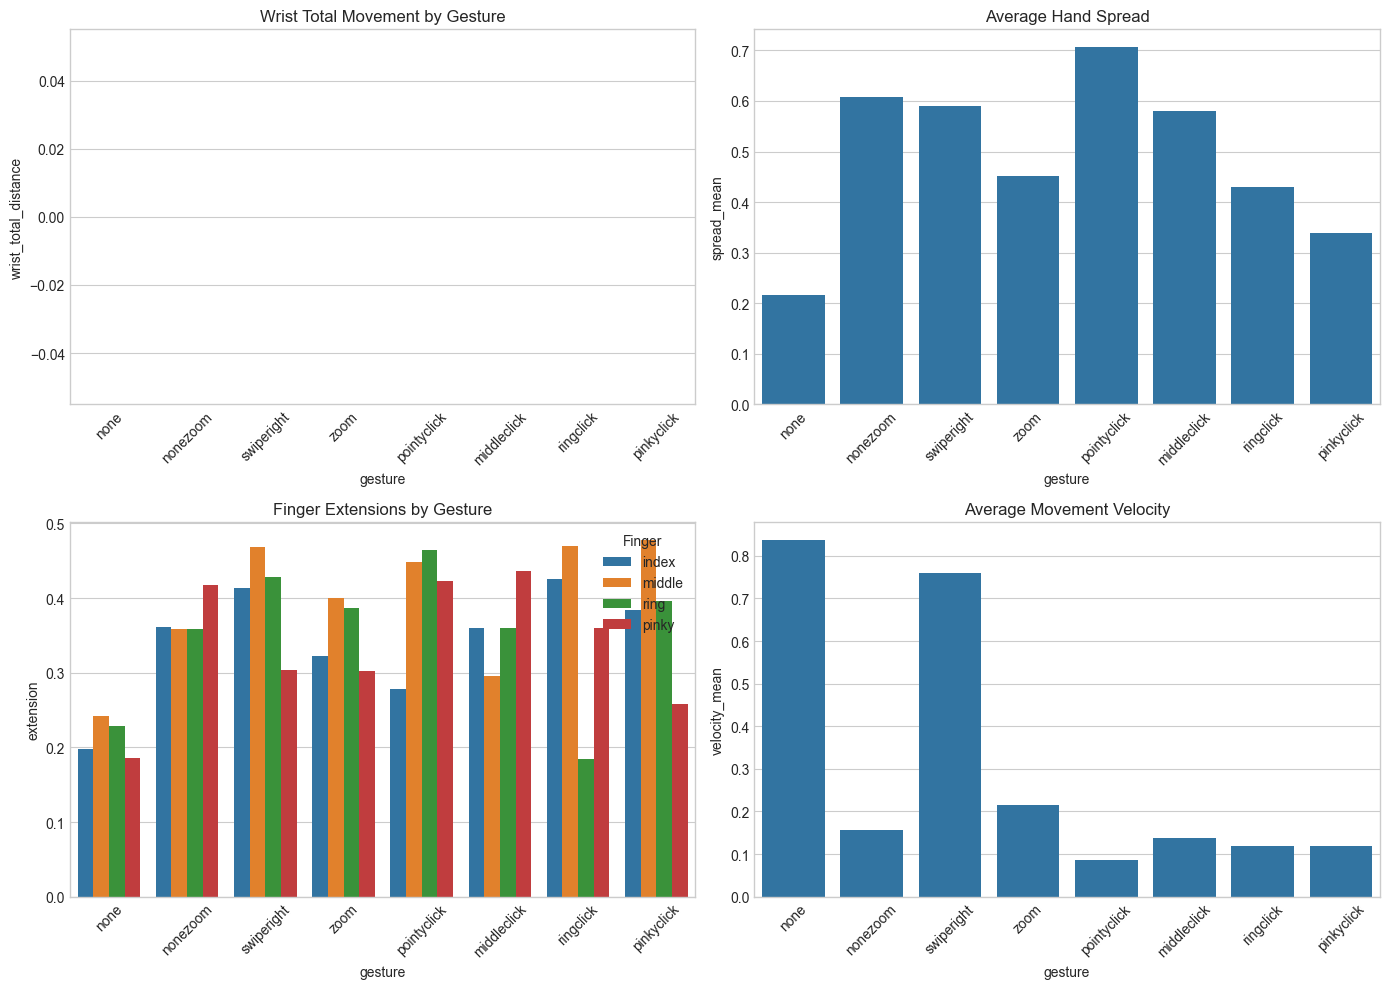

In [33]:
# Visualize distinguishing features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Wrist movement
gesture_order = df_features.sort_values('wrist_total_distance', ascending=False)['gesture'].tolist()
sns.barplot(data=df_features, x='gesture', y='wrist_total_distance', order=gesture_order, ax=axes[0, 0])
axes[0, 0].set_title('Wrist Total Movement by Gesture')
axes[0, 0].tick_params(axis='x', rotation=45)

# Hand spread
sns.barplot(data=df_features, x='gesture', y='spread_mean', ax=axes[0, 1])
axes[0, 1].set_title('Average Hand Spread')
axes[0, 1].tick_params(axis='x', rotation=45)

# Finger extensions comparison
finger_cols = [c for c in df_features.columns if 'extension_mean' in c]
df_melted = df_features.melt(id_vars='gesture', value_vars=finger_cols, var_name='finger', value_name='extension')
df_melted['finger'] = df_melted['finger'].str.replace('_extension_mean', '')
sns.barplot(data=df_melted, x='gesture', y='extension', hue='finger', ax=axes[1, 0])
axes[1, 0].set_title('Finger Extensions by Gesture')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='Finger', loc='upper right')

# Velocity
sns.barplot(data=df_features, x='gesture', y='velocity_mean', ax=axes[1, 1])
axes[1, 1].set_title('Average Movement Velocity')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../docs/distinguishing_features.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Key Findings

### Observations:

1. **Swipe gestures** show high wrist movement (horizontal motion)
2. **Zoom gestures** show changing hand spread (thumb-pinky distance)
3. **Click gestures** show specific finger extensions:
   - `pointyclick`: High index finger extension
   - `middleclick`: High middle finger extension
   - `ringclick`: High ring finger extension
   - `pinkyclick`: High pinky finger extension
4. **None** gesture shows minimal movement (baseline)

### Implications for Feature Engineering:

1. **Velocity features** - Critical for detecting swipes
2. **Hand spread features** - Important for zoom detection
3. **Finger angle features** - Distinguishes click types
4. **Bounding box** - Helps with distance awareness

## Next Steps

Continue to:
- **03_feature_engineering.ipynb** - Implement and test computed features
- **04_model_exploration.ipynb** - Compare model architectures